久保拓弥『データ解析のための統計モデリング入門』をJuliaでやってみます。

* 久保さんの書籍ページ：http://hosho.ees.hokudai.ac.jp/~kubo/ce/IwanamiBook.html
* Amazon.co.jp：https://amzn.to/2Cg5vDJ

# 第3章 一般化線型モデル（GLM）---ポアソン回帰---

In [1]:
using CSV
using DataFrames
using GLM
using Plots
pyplot();
using Distributions
using StatsPlots

ArgumentError: ArgumentError: Package StatsPlots not found in current path:
- Run `import Pkg; Pkg.add("StatsPlots")` to install the StatsPlots package.


説明変数として体サイズ（$x_i$）と施肥効果（$f_i$）、応答変数として種子数（$y_i$）があるとする。

## 3.2 観測されたデータの概要を調べる（p.41）

In [2]:
d = CSV.read("data3a.csv")

,y,x,f
,Int64⍰,Float64⍰,String⍰
1,6,8.31,C
2,6,9.44,C
3,6,9.5,C
4,12,9.07,C
5,10,10.16,C
6,4,8.32,C
7,9,10.61,C
8,9,10.06,C
9,9,9.93,C


In [3]:
DataFrames.describe(d)   # Rのsummaryっぽいやつ

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Union…,Int64,DataType
1,y,7.83,2,8.0,15,,0,Int64
2,x,10.0891,7.19,10.155,12.4,,0,Float64
3,f,,C,,T,2,0,String


In [4]:
d.x

100-element Array{Union{Missing, Float64},1}:
  8.31
  9.44
  9.5 
  9.07
 10.16
  8.32
 10.61
 10.06
  9.93
 10.43
 10.36
  ⋮   
  8.85
 11.2 
  9.86
 11.54
 10.03
 11.88
  9.15
  8.52
 10.24
 10.86
  9.97

In [5]:
typeof(d)

DataFrame

In [6]:
typeof(d[:x])

Array{Union{Missing, Float64},1}

In [7]:
typeof(d[:f])

Array{Union{Missing, String},1}

## 3.3 統計モデリングの前にデータを図示する（p.44）

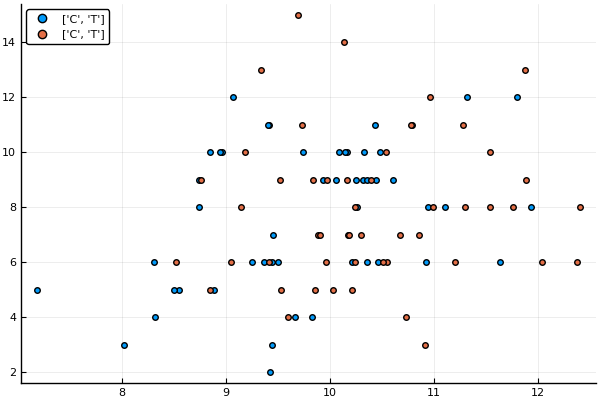

In [8]:
# 素のままのPlots.jlを使った場合
scatter(reshape(d[:x], (50, 2)), reshape(d[:y], (50, 2)), label=["C", "T"], legend=:topleft)

In [9]:
# StatPlots.jlを使った場合
@df d scatter(:x, :y, group=:f)

LoadError: UndefVarError: @df not defined

In [10]:
@df d boxplot(:f, :y, legend=false)

LoadError: UndefVarError: @df not defined

### 3.4.1 線形予測子と対数リンク関数（p.47）

たとえばある個体$i$の平均種子数$\lambda_i$が

$$ \lambda_i = \exp\left(\beta_1 + \beta_2 x_i\right) $$

とあらわせるとき、これを

$$ \log_e\lambda_i = \beta_1 + \beta_2 x_i $$

と変形し、右辺（$\beta_1 + \beta_2 x_i$）が**線形予測子**（_linear predictor_）、左辺の関数（$\log_e$）が**リンク関数**（_link function_）となる。

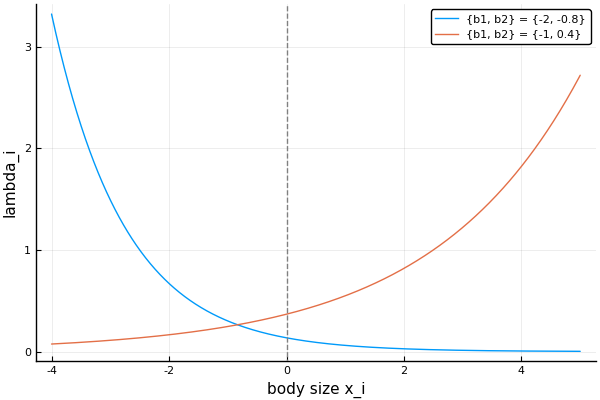

In [11]:
x = range(-4, stop=5, length=1001);
plot(x, exp.(-2 .+ -0.8x), label="{b1, b2} = {-2, -0.8}",
  xlabel="body size x_i", ylabel="lambda_i")
plot!(x, exp.(-1 .+ 0.4x), label="{b1, b2} = {-1, 0.4}")
vline!([0], color=:grey, linestyle=:dash, label="")

### 3.4.2 あてはめとあてはまりの良さ（p.49）

モデルを格納する変数名に`fit`を使うと関数名とバッティングするので、ここでは`fit1`を使用している。

In [12]:
fit1 = glm(
    @formula(y ~ x),   # モデル式
    d,                 # データフレームの指定
    Poisson(),         # 確率分布の指定
    LogLink())         # リンク関数の指定

StatsModels.DataFrameRegressionModel{GeneralizedLinearModel{GlmResp{Array{Float64,1},Poisson{Float64},LogLink},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: y ~ 1 + x

Coefficients:
              Estimate Std.Error z value Pr(>|z|)
(Intercept)    1.29172  0.363686 3.55174   0.0004
x            0.0756619 0.0356042 2.12509   0.0336


In [13]:
# 推定値
fit1.model.pp.beta0

2-element Array{Float64,1}:
 1.291720838655208  
 0.07566191453957867

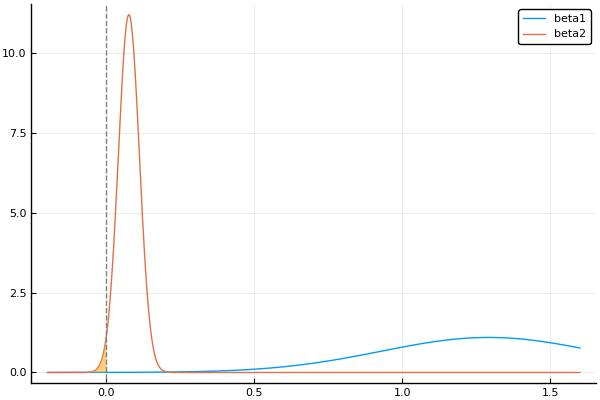

In [14]:
# Figure 3.6
th = range(-0.2, stop=1.6, length=1001);
plot(th, pdf.(Normal(1.29172, 0.363686), th), label="beta1")
plot!(th, pdf.(Normal(0.0756619, 0.0356042), th), label="beta2")
plot!(th[th .<= 0], pdf.(Normal(0.0756619, 0.0356042), th[th .<= 0]), linealpha=0, fill=(0, 0.5, :orange), label="")
vline!([0], color=:grey, linestyle=:dash, label="")

In [15]:
# 最大対数尤度（maximum log likelihood）...あてはまりの良さ（goodness of fit）とも
loglikelihood(fit1)

-235.38625076986077

### 3.4.3 ポアソン回帰モデルによる予測（p.53）
$ \lambda = \exp\left(\beta_1 + \beta_2 x\right) $をプロットしてみる。

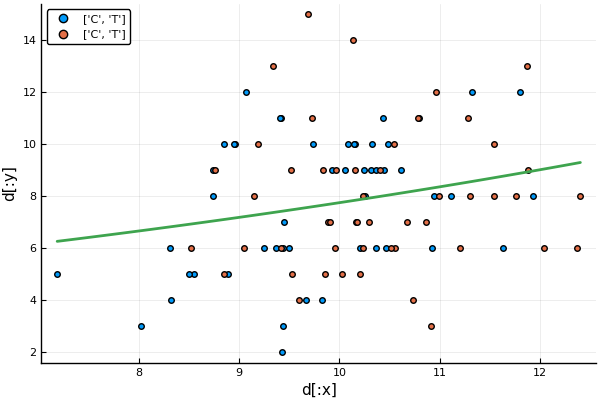

In [16]:
xx = range(minimum(d[:x]), stop=maximum(d[:x]), length=100)
scatter(reshape(d[:x], (50, 2)), reshape(d[:y], (50, 2)), label=["C", "T"], xlabel="d[:x]", ylabel="d[:y]", legend=:topleft)
plot!(xx, exp.(1.29172 .+ 0.0756619 * xx), linewidth=2, label="")

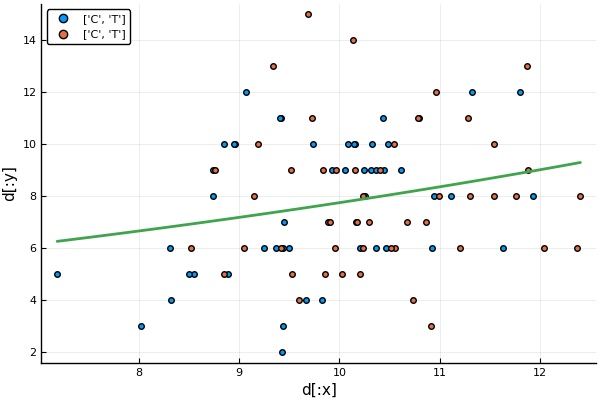

In [17]:
# predictを使う方法
xx = range(minimum(d[:x]), stop=maximum(d[:x]), length=100)
yy = predict(fit1, DataFrame(x=xx))
scatter(reshape(d[:x], (50, 2)), reshape(d[:y], (50, 2)), label=["C", "T"], xlabel="d[:x]", ylabel="d[:y]", legend=:topleft)
plot!(xx, yy, linewidth=2, label="")

## 3.5 説明変数が因子型の統計モデル（p.54）

$$ \lambda_i = \exp\left(\beta_1 + \beta_3 d_i\right) $$

In [18]:
fit1_f = glm(@formula(y ~ f), d, Poisson(), LogLink())

StatsModels.DataFrameRegressionModel{GeneralizedLinearModel{GlmResp{Array{Float64,1},Poisson{Float64},LogLink},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: y ~ 1 + f

Coefficients:
              Estimate Std.Error  z value Pr(>|z|)
(Intercept)    2.05156  0.050702   40.463   <1e-99
f: T         0.0127716 0.0714756 0.178684   0.8582


In [19]:
loglikelihood(fit1_f)

-237.6272569606868

## 3.6 説明変数が数量型＋因子型の統計モデル（p.57）

$$ \lambda_i = \exp\left(\beta_1 + \beta_2 x + \beta_3 d_i\right) $$
$$ \log\lambda_i = \beta_1 + \beta_2 x + \beta_3 d_i $$

In [20]:
fit1_all = glm(@formula(y ~ x + f), d, Poisson(), LogLink())

StatsModels.DataFrameRegressionModel{GeneralizedLinearModel{GlmResp{Array{Float64,1},Poisson{Float64},LogLink},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: y ~ 1 + x + f

Coefficients:
               Estimate Std.Error   z value Pr(>|z|)
(Intercept)     1.26311  0.369629   3.41722   0.0006
x             0.0800726 0.0370369   2.16197   0.0306
f: T         -0.0319994 0.0743789 -0.430221   0.6670


In [21]:
loglikelihood(fit1_all)

-235.2937192424937

In [22]:
# ここまでの最大対数尤度まとめ
println("  fit1_x: $(round(loglikelihood(fit1), digits=2))")
println("  fit1_f: $(round(loglikelihood(fit1_f), digits=2))")
println("fit1_all: $(round(loglikelihood(fit1_all), digits=2))")

  fit1_x: -235.39
  fit1_f: -237.63
fit1_all: -235.29


### 3.6.1 対数リンク関数のわかりやすさ：かけ算される効果

「対数リンク関数では要因の効果が積であらわされる」ので、
$$ \lambda_i = \exp\left(\beta_1\right)\times\exp\left(\beta_2 x\right)\times\exp\left(\beta_3 d_i\right) = \mathrm{定数}\times\mathrm{体サイズの効果}\times\mathrm{施肥処理の効果} $$
から、次によってそれぞれの効果の大きさがわかる。（たとえば肥料をやると種子の平均数が0.97倍になる）

In [23]:
println("exp(beta1): $(round(exp(1.26311), digits=2))")
println("exp(beta2): $(round(exp(0.0800726), digits=2))")
println("exp(beta3): $(round(exp(-0.0319994), digits=2))")

exp(beta1): 3.54
exp(beta2): 1.08
exp(beta3): 0.97


**恒等リンク関数**（_identity link function_）を使用した場合は

In [24]:
fit1_id = glm(@formula(y ~ x + f), d, Poisson(), IdentityLink())

StatsModels.DataFrameRegressionModel{GeneralizedLinearModel{GlmResp{Array{Float64,1},Poisson{Float64},IdentityLink},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: y ~ 1 + x + f

Coefficients:
              Estimate Std.Error   z value Pr(>|z|)
(Intercept)    1.26602    2.8432  0.445279   0.6561
x             0.660745  0.289658   2.28112   0.0225
f: T         -0.204678  0.582247 -0.351532   0.7252


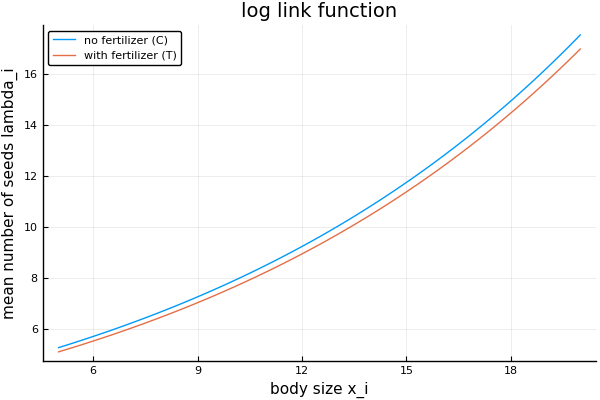

In [25]:
# log link function
xx = range(5, stop=20, length=100)
yy1_C = predict(fit1_all, DataFrame(x=xx, f="C"))
yy1_T = predict(fit1_all, DataFrame(x=xx, f="T"))
plot(xx, yy1_C, label="no fertilizer (C)", legend=:topleft,
    xlabel="body size x_i", ylabel="mean number of seeds lambda_i", title="log link function")
plot!(xx, yy1_T, label="with fertilizer (T)")

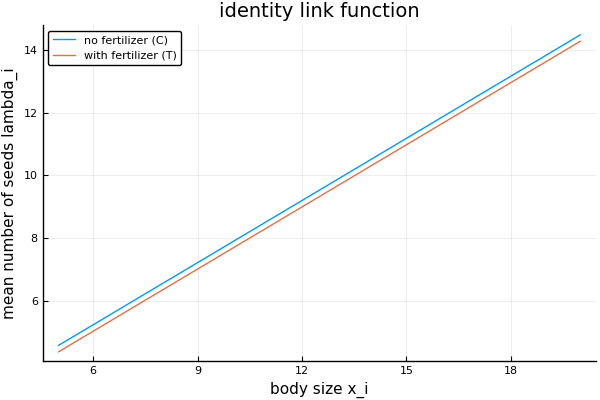

In [26]:
# identity link function
yy1_C = predict(fit1_id, DataFrame(x=xx, f="C"))
yy1_T = predict(fit1_id, DataFrame(x=xx, f="T"))
plot(xx, yy1_C, label="no fertilizer (C)", legend=:topleft,
    xlabel="body size x_i", ylabel="mean number of seeds lambda_i", title="identity link function")
plot!(xx, yy1_T, label="with fertilizer (T)")